# Importing

In [ ]:
import pandas as pd
import numpy as np
import os
import joblib

# data transform
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer

# models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# models check
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

# for load the data pre-preparation function
import importlib.util

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

import os

In [3]:
np.set_printoptions(suppress=False)

work_dir = r'C:\Users\krasavica\Desktop\Projekty - DS\python-project-ApartmentPriceAnalysis'
os.chdir(work_dir)

pd.set_option('display.float_format', '{:.2f}'.format)

In [4]:
# loading functions from the file
module_name = f"pipeline_pre-processing"
module_path = f"pipeline_pre-processing.py"

spec = importlib.util.spec_from_file_location(module_name, module_path)
module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(module)

In [5]:
# setting of plots
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_theme(style="darkgrid")
plt.close()

In [ ]:
data_initial = pd.read_csv('data_2024-01.csv', index_col = 0)
data_for_analysis = module.preliminary_transform(data_initial, True)

# Functions for processing data

After applying the **preliminary_transform** function with data preprocessing defined in the file **pipeline_pre-processing.py**, the data must be splited into training and test sets and coded them for modeling.<br>For this purpose, the **prepare_train_test_data** function was defined below. This function:
1. divides the dataset into training and test datasets
2. applies **cleaning_data** function defined in the file **pipeline_pre-processing.py**
3. codes variables for modeling purposes using the following functions defined below:
    * **one_hot_encode_train_test** - One-hot encodes selected categorical features with category dropping for stability.
    * **scale_train_test** - Standardizes numerical features in training and test datasets using z-score normalization.
    * **kNN_impute_train_test** - Performs K-Nearest Neighbors (KNN) imputation on selected features in training and test datasets.



### one_hot_encode

In [8]:
def one_hot_encode_train_test(X_train_to_encode, X_test_to_encode, features_to_onehotencode):
    
    """
    One-hot encodes selected categorical features with category dropping for stability.
    
    Parameters:
    -----------
    X_train_to_encode : pd.DataFrame
        Training data.
    X_test_to_encode : pd.DataFrame
        Test data.
    features_to_onehotencode : list of str
        List of categorical feature names to be one-hot encoded.

    Returns:
    --------
    X_train : pd.DataFrame
        Training data with encoded features.
    X_test : pd.DataFrame
        Test data with encoded features.
    """
    
    # Create copies of the original datasets to avoid modifying them in-place
    X_train = X_train_to_encode.copy()
    X_test = X_test_to_encode.copy()
    
    for column in features_to_onehotencode:
        # Define categories to drop if found
        categories_to_drop = ['nie podano', 'inny', 'wtórny', 'prywatny', 'opolskie']
        
        # Decide which category to drop fot this feature
        cat_to_drop = None
        for cat in categories_to_drop:
            if cat in X_train[column].unique():
                cat_to_drop = [cat]
                break
                
        # Create and fit the encoder
        encoder = OneHotEncoder(drop = cat_to_drop if cat_to_drop else 'first',
                                sparse_output = False,
                                handle_unknown='ignore')
        encoder.fit(X_train[[column]])
        
        # Column names for output
        cols = encoder.get_feature_names_out([column])
        
        # Transform both train and test
        X_train_encoded = pd.DataFrame(encoder.transform(X_train[[column]]), columns=cols, index=X_train.index)
        X_test_encoded = pd.DataFrame(encoder.transform(X_test[[column]]), columns=cols, index=X_test.index)
        
        # Join with original data
        X_train = pd.concat([X_train, X_train_encoded], axis=1)
        X_test = pd.concat([X_test, X_test_encoded], axis=1)
        
    # Drop the original categorical column
    X_train.drop(features_to_onehotencode, axis=1, inplace=True)
    X_test.drop(features_to_onehotencode, axis=1, inplace=True)
    
    return X_train, X_test

### scale

In [9]:
def scale_train_test(X_train_to_scale, X_test_to_scale):
    
    """
    Standardizes numerical features in training and test datasets using StandardScaler.

    This function applies z-score normalization to ensure each feature has a mean of 0
    and standard deviation of 1. It fits the scaler only on the training data and uses
    the same transformation on the test data to avoid data leakage.

    Parameters:
    -----------
    X_train_to_scale : pd.DataFrame
        The training dataset with numerical features to be standardized.

    X_test_to_scale : pd.DataFrame
        The test dataset with the same structure as X_train_to_scale.

    Returns:
    --------
    X_train : pd.DataFrame
        The standardized training dataset.

    X_test : pd.DataFrame
        The standardized test dataset, transformed using the scaler fitted on training data.
    """
    # Create copies of the original datasets to avoid modifying them in-place
    X_train = X_train_to_scale.copy()
    X_test = X_test_to_scale.copy() 
    
    # Create and fit the scaler
    scaler = StandardScaler()

    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns, index = X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns, index = X_test.index)
        
    return X_train, X_test

### kNN_impute

In [10]:
def kNN_impute_train_test(X_train_to_impute, X_test_to_impute,
                          features_for_kNN_impute, features_to_onehotencode):       
    
    """
    Performs K-Nearest Neighbors (KNN) imputation on selected features in training and test datasets.

    This function uses the KNNImputer to fill in missing values in specified features by
    leveraging similarity between instances. It also automatically handles one-hot encoded
    categorical variables by including all derived columns in the imputation process.

    Parameters:
    -----------
    X_train_to_impute : pd.DataFrame
        Training dataset containing missing values to be imputed.

    X_test_to_impute : pd.DataFrame
        Test dataset with the same structure as the training data.

    features_for_kNN_impute : list of str
        List of original feature names to apply KNN imputation to.
        If a feature has been one-hot encoded, columns after encoding
        will be included in the imputation process.

    Returns:
    --------
    X_train : pd.DataFrame
        Training dataset with missing values imputed using KNN.

    X_test : pd.DataFrame
        Test dataset imputed using the same fitted KNN model from training data.
    """
    
    # Create copies of the original datasets to avoid modifying them in-place
    X_train = X_train_to_impute.copy()
    X_test = X_test_to_impute.copy()
    features_for_kNN_impute_new = features_for_kNN_impute.copy()
    
    # Identify which features were one-hot encoded
    encoded_vars = list(set(features_for_kNN_impute) & set(features_to_onehotencode))
    
    # Replace original variable name with all derived one-hot encoded columns
    for var in encoded_vars:
        col_after_encode = [col for col in X_train.columns if col.startswith(var)]
        features_for_kNN_impute_new.remove(var)
        features_for_kNN_impute_new = features_for_kNN_impute_new + col_after_encode
        
    # Create the imputer
    imputer = KNNImputer()
    
    # Fit and apply KNN imputation to the selected columns
    X_train[features_for_kNN_impute_new] = imputer.fit_transform(X_train[features_for_kNN_impute_new])
    X_test[features_for_kNN_impute_new] = imputer.transform(X_test[features_for_kNN_impute_new])
    
    return X_train, X_test

### prepare_train_test_data

In [11]:
def prepare_train_test_data (data, balanced_train, test_size, random_seed):
    
    """
    Prepares and processes the dataset for model training and evaluation by applying
    feature selection, encoding, scaling, and missing value imputation.

    The function loads preprocessing configuration from a saved dictionary and performs the following steps:
    1. Splits the dataset into train and test sets.
    2. Cleans missing and outlier values in train and test sets.
    3. Selects relevant features and target column.
    3. Applies one-hot encoding to categorical features.
    4. Scales numeric features using StandardScaler.
    5. Imputes missing values using K-Nearest Neighbors imputation.

    Parameters:
    -----------
    data : pd.DataFrame
        The full dataset to be prepared for training and testing.
    
    to_delete_from_test_set : bool
        Indicates whether outlier observations will remain in the test set or be removed. Default is set to True.

    test_size : float
        Proportion of the dataset to include in the test split (e.g., 0.2 for 20%).

    random_seed : int
        Random seed to ensure reproducibility of the train-test split.

    Returns:
    --------
    X_train_imputed : pd.DataFrame
        Fully preprocessed training feature set.

    X_test_imputed : pd.DataFrame
        Fully preprocessed test feature set.

    y_train : pd.Series
        Target variable for training data.

    y_test : pd.Series
        Target variable for test data.
    """
    
    # Load preprocessing configuration with selected features and target definition
    model_features_dict = joblib.load("1. Data Preparation/model_features_dict.joblib")
    
    features_to_use = model_features_dict['features_to_use']
    target = model_features_dict['target']
    features_to_onehotencode = model_features_dict['features_to_onehotencode']
    features_for_kNN_impute = model_features_dict['features_for_kNN_impute']
    
    # Validate that all required features exist in the provided dataset
    if all(x in data.columns for x in model_features_dict['features_to_use']) == 0:
        print("The dataset does not have all the variables defined for modeling")
    
    # Split the dataset into training and testing sets
    train_data, test_data = train_test_split(data,
                                             test_size = test_size,
                                             random_state = random_seed)

    # Clean the train and test data
    train_cleaned_data = module.cleaning_data(train_data, train_dataset = True)
    
    test_cleaned_data = module.cleaning_data(test_data,
                                             train_dataset = False,
                                             to_delete_from_test_set = True)
    
    # Since the test set is needed for the evaluation of the model, it must not contain missing data in the target variable
    test_cleaned_data = test_cleaned_data.dropna(subset = target)

    # Extract features (X) and target variable (y)
    X_train = train_cleaned_data[features_to_use]
    y_train = train_cleaned_data[target]

    X_test = test_cleaned_data[features_to_use]
    y_test = test_cleaned_data[target]
    
    # Ensure NaNs are np.nan, not pd.NA
    X_train = X_train.replace({pd.NA: np.nan})
    X_test = X_test.replace({pd.NA: np.nan})
    
    # One-hot encode categorical features
    X_train_encoded, X_test_encoded = one_hot_encode_train_test(X_train, X_test, features_to_onehotencode)
    
    # Scale features using StandardScaler
    X_train_scaled, X_test_scaled = scale_train_test(X_train_encoded, X_test_encoded)
    
    # Impute missing values using KNN imputer
    X_train_imputed, X_test_imputed = kNN_impute_train_test(X_train_scaled, X_test_scaled,
                                                            features_for_kNN_impute, features_to_onehotencode)
    
    return X_train_imputed, X_test_imputed, y_train, y_test

# Data preparation

In [ ]:
# Transform data for modeling
(X_train,
 X_test,
 y_train,
 y_test) = prepare_train_test_data(data_for_analysis,
                                   balanced_train = False,
                                   test_size = 0.2, random_seed = 99)


                  W zbiorze wystąpiły braki w cechach: 'typ budynku', 'powierzchnia',
                  'liczba pokoi', 'rynek', 'ogłoszeniodawca', 'miasto', 'województwo'.
                  Do otrzymania prognozy wszystkie z powyższych cech
                  muszą być wypełnione.
                  Obserwacje te zostały usunięte ze zbioru do predykcji.
                  

                      W zbiorze wystąpiły obserwację o skrajnych wartościach
                      ze względu na zaproponowaną cenę, powierzchnię, piętro lub rok budynku.
                      Obserwacje te zostały usunięte ze zbioru do predykcji.
                      


# Functions for modeling
For model evaluation and selection, 4 functions were defined:
1. **modify_train_data** - transforms the data on which the model is trained by overestimating or underestimating values for parts of the data<br>
   *During the first attempts at model building, it was noted that regardless of the model and parameters, the model overestimates the predicted values for low-priced apartments and underestimates the values for expensive apartments. Therefore, in order to compensate for this tendency, it was decided, in addition to the models on the original data, to build models on the modified training data, where the price is even lower for low-priced apartments and even higher for expensive ones.*
2. **model_summary** - evaluates and visualizes modeling results vs. actual values for both model on original data and modified data.
3. **compare_unbalanced_balanced_pred** - calculates RMSE across different price bins and compares RMSE performance of two regression models: one trained on the original dataset, and the other trained on a modified version.
4. **model_selection** - for selecting the best parameters among those given using GridSearchCV.

### modify_train_data

In [ ]:
def modify_train_data(X_train, y_train,
                      lower_thresholds = [0], lower_wages = [1],
                      upper_thresholds = [1_500_000], upper_wages = [1]):
    
    """
    Modify the target variable 'y_train' based on specified lower and upper thresholds 
    and associated multiplicative weights.

    Parameters
    ----------
    X_train : pandas.DataFrame or numpy.ndarray
        Feature matrix used for training.
    
    y_train : pandas.Series or numpy.ndarray
        Target vector used for training.

    lower_thresholds : list of float, optional (default = [0])
        Threshold values below which the corresponding lower_wages will be applied.
        Each threshold defines a cutoff, and values below it will be multiplied.

    lower_wages : list of float, optional (default = [1])
        Multiplicative weights applied to target values below each corresponding
        value in 'lower_thresholds'.

    upper_thresholds : list of float, optional (default = [1_500_000])
        Threshold values above which the corresponding upper_wages will be applied.
        Each threshold defines a cutoff, and values above it will be multiplied.

    upper_wages : list of float, optional (default = [1])
        Multiplicative weights applied to target values above each corresponding
        value in 'upper_thresholds'.

    Returns
    -------
    X_train : unchanged
        The input features passed through without modification.

    y_train_copy : pandas.Series or numpy.ndarray
        A modified version of `y_train`, where values below/above the defined 
        thresholds have been scaled accordingly.

    """

    # Create a copy of y_train to avoid modifying the original target data
    y_train_copy = y_train.copy()
    
    # Apply scaling to values below the given lower thresholds
    for i in range(len(lower_thresholds)):
        condition = y_train_copy < lower_thresholds[i]
        y_train_copy[condition] = y_train_copy[condition] * lower_wages[i]

    # Apply scaling to values above the given upper thresholds
    for i in range(len(upper_thresholds)):
        condition = y_train_copy > upper_thresholds[i]
        y_train_copy[condition] = y_train_copy[condition] * upper_wages[i]

    # Return the original features and the modified target
    return X_train, y_train_copy

### model_summary

In [86]:
def model_summary(regressor_list, title, X_test = X_test, y_test = y_test):
    
    """
    Plot prediction vs. actual values and model performance metrics (RMSE and R²)
    for two regression models.

    This function compares two regression models visually and numerically by:
    - Plotting predicted vs. actual values as scatter plots
    - Adding a red line showing average predicted values per price bin
    - Drawing a green diagonal line representing a perfect prediction
    - Annotating each subplot with RMSE and R² metrics

    Parameters
    ----------
    regressor_list : list
        A list of two fitted regression model objects that implement `.predict(X)`.

    title : list of str
        A list of two strings used as subplot titles for each model's visualization.

    X_test : array-like or pandas.DataFrame, optional
        The feature set to be used for prediction. By default, uses a globally defined `X_test`.

    y_test : array-like or pandas.Series, optional
        The true target values. By default, uses a globally defined `y_test`.

    Returns
    -------
    None
        Displays a matplotlib figure with two subplots side-by-side.
    
    Notes
    -----
    - Prediction binning uses price bins from 100,000 to 1,500,000 in steps of 100,000.
    """

    # Create a figure with two vertical subplots
    fig, ax = plt.subplots(2, 1, figsize=(8, 8))

    for i in range(2):
        # Get the i-th model from the list
        regressor = regressor_list[i]

        # Generate predictions for the test set
        prediction = regressor.predict(X_test)

        # Calculate performance metrics
        rmse = round(np.sqrt(metrics.mean_squared_error(y_test, prediction)), 2)
        r2 = round(metrics.r2_score(y_test, prediction), 3)

        # Scatter plot: actual vs predicted
        sns.scatterplot(x=y_test,
                        y=prediction,
                        alpha=0.25,
                        ax=ax[i])

        # Bin the actual values to visualize average predictions by price segment
        y_test_cut = pd.cut(
            y_test,
            bins=range(100_000, 1_500_001, 100_000),
            labels=np.arange(150_000, 1_450_001, 100_000)
        )

        # Prepare DataFrame with predicted values and their corresponding price bins
        pred_df = pd.DataFrame(prediction,
                               index=y_test.index,
                               columns=["pred"])
        df_for_plot = pd.concat([y_test_cut.rename("price"), pred_df], axis=1)
        df_for_plot = df_for_plot.groupby("price", observed=False).mean()

        # Line plot: average prediction per price bin (in red)
        sns.lineplot(x=df_for_plot.index, y=df_for_plot['pred'],
                     color="r",
                     linewidth=2,
                     ax=ax[i])

        # Diagonal line for reference (perfect prediction)
        min_y = y_test.min()
        max_y = y_test.max()
        sns.lineplot(x=[min_y, max_y], y=[min_y, max_y],
                     color="g",
                     linewidth=2,
                     ax=ax[i])

        # Set axis labels and title
        ax[i].set_title(title[i])
        ax[i].set_xlabel("Actual")
        ax[i].set_ylabel("Predict")

        # Add text annotation with RMSE and R²
        x_lim_max = ax[i].get_xlim()[1]
        y_lim_max = ax[i].get_ylim()[1]
        ax[i].text(x_lim_max * 0.05,
                   y_lim_max * 0.75,
                   f'Indicators:\nRMSE: {"{:,}".format(rmse)} zł\nR²: {r2}')

        # Use plain number format on both axes
        ax[i].ticklabel_format(style='plain', axis='both')

    # Adjust subplot spacing
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.87,
                        wspace=0.15,
                        hspace=0.45)

    # Show the plots
    plt.show()

### compare_unbalanced_balanced_pred

In [80]:
def compare_unbalanced_balanced_pred(regressor, regressor_modified,
                                     X_test = X_test, y_test = y_test):

    """
    Compare RMSE performance of two regression models: one trained on the original 
    dataset, and the other trained on a modified version.

    This function evaluates how each model performs across different price bins,
    and calculates absolute and relative differences in RMSE per bin.

    Parameters
    ----------
    regressor : object
        A trained regression model (e.g., from scikit-learn) fitted on the original data.
        Must implement a '.predict(X)' method.

    regressor_modified : object
        A trained regression model fitted on a modified version of the training data
        (e.g., balanced, resampled, or reweighted).
        Must also implement '.predict(X)'.
    
    X_test : array-like or pandas.DataFrame, optional
        The feature set to be used for prediction. By default, uses a globally defined `X_test`.

    y_test : array-like or pandas.Series, optional
        The true target values. By default, uses a globally defined `y_test`.

    Returns
    -------
    rmse_df : pandas.DataFrame
        A summary DataFrame with the following columns per price bin:
        - price_bin : the bin label
        - count : number of samples in the bin
        - rmse_pred : RMSE of the original model
        - rmse_pred_mod : RMSE of the modified model
        - is_modiefied_better : True if the modified model performed better (lower RMSE)
        - rmse_diff : absolute RMSE difference (original - modified)
        - rmse_diff_per : relative RMSE improvement as a fraction of original RMSE

    Notes
    -----
    - Bins are defined between 100,000 and 1,500,000 in 100,000 increments.
    """

    # Bin actual target values into price ranges
    x_bins = pd.cut(
        y_test,
        bins=range(100_000, 1_500_001, 100_000),
        labels=np.arange(200_000, 1_500_001, 100_000)
    )

    # Predict using the original model
    pred = regressor.predict(X_test)
    pred_df = pd.DataFrame(pred, index=y_test.index, columns=["pred"])

    # Predict using the modified (balanced or reweighted) model
    pred_mod = regressor_modified.predict(X_test)
    pred_mod_df = pd.DataFrame(pred_mod, index=y_test.index, columns=["pred_mod"])

    # Combine actuals and predictions into a single DataFrame
    combined_df = pd.concat([x_bins, y_test, pred_df, pred_mod_df], axis=1)
    combined_df.columns = ["price_bin", "actual", "pred", "pred_mod"]

    # Compute RMSE for both models within each price bin
    rmse_df = combined_df.groupby("price_bin", observed=False).apply(
        lambda g: pd.Series({
            "count": len(g['actual']),
            "rmse_pred": metrics.root_mean_squared_error(g['actual'], g['pred']),
            "rmse_pred_mod": metrics.root_mean_squared_error(g['actual'], g['pred_mod'])
        }),
        include_groups=False
    ).reset_index()

    # Add overall RMSE values across all data (not grouped by bin)
    rmse_df.loc[len(rmse_df)] = {
        "price_bin": "All",
        "count": len(combined_df['actual']),
        "rmse_pred": metrics.root_mean_squared_error(combined_df['actual'], combined_df['pred']),
        "rmse_pred_mod": metrics.root_mean_squared_error(combined_df['actual'], combined_df['pred_mod'])
    }
    
    # Flag bins where the modified model performs better (lower RMSE)
    rmse_df["is_modiefied_better"] = rmse_df["rmse_pred"] > rmse_df["rmse_pred_mod"]

    # Calculate absolute and relative RMSE differences
    rmse_df["rmse_diff"] = rmse_df["rmse_pred"] - rmse_df["rmse_pred_mod"]
    rmse_df["rmse_diff_per"] = rmse_df["rmse_diff"] / rmse_df["rmse_pred"]

    return rmse_df


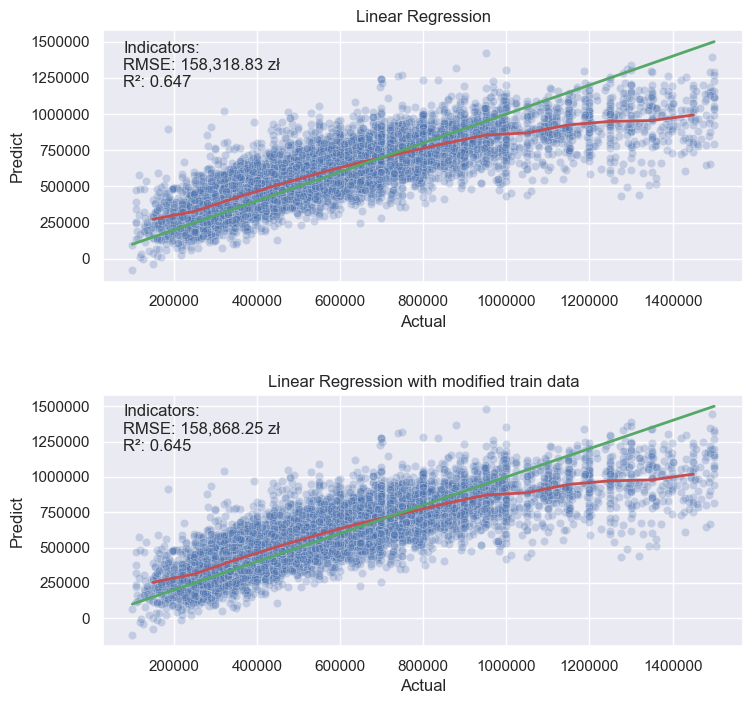

,price_bin,count,rmse_pred,rmse_pred_mod,is_modiefied_better,rmse_diff,rmse_diff_per
0,200000,191.00,164023.32,158470.81,True,5552.50,0.03
1,300000,702.00,135202.82,134949.24,True,253.57,0.00
2,400000,1257.00,131691.83,133774.95,False,-2083.11,-0.02
3,500000,1433.00,122668.39,127325.92,False,-4657.52,-0.04
4,600000,1363.00,118927.44,125585.55,False,-6658.11,-0.06
5,700000,1151.00,123938.83,132007.86,False,-8069.02,-0.07
6,800000,747.00,128511.57,134389.38,False,-5877.80,-0.05
7,900000,506.00,141072.37,142899.72,False,-1827.35,-0.01
8,1000000,357.00,179274.10,177898.13,True,1375.97,0.01
9,1100000,156.00,239165.57,230097.06,True,9068.51,0.04


In [87]:
# Reweight y_train: decrease low prices, increase high prices
(X_train_modified,
 y_train_modified) = modify_train_data(X_train, y_train,
                                       [250_000], [0.7],
                                       [1_200_000], [1.1])

# Train model on original data
linear = LinearRegression(n_jobs = -2)
linear.fit(X_train, y_train)

# Train model on modified data
linear_modified = LinearRegression(n_jobs = -2)
linear_modified.fit(X_train_modified, y_train_modified)

# Show prediction plots and metrics for both models
model_summary([linear, linear_modified],
              ["Linear Regression", "Linear Regression with modified train data"])

# Compare RMSE per price bin for both models
compare_unbalanced_balanced_pred(linear, linear_modified)


### model_selection

In [ ]:
def model_selection(regressor, param_grid, X_train, y_train,
                    X_test = X_test, y_test = y_test):

    """
    Perform model selection using GridSearchCV and return the best model.

    This function applies grid search with cross-validation to find the optimal hyperparameters
    for a given regression model. It evaluates performance using negative mean squared error
    and prints out training and test scores as well as the best parameters found.

    Parameters
    ----------
    regressor : estimator object
        The base regressor (e.g., RandomForestRegressor, XGBRegressor) to be tuned.

    param_grid : dict
        Dictionary with parameters names ('str') as keys and lists of parameter settings to try as values.

    X_train : array-like or pandas.DataFrame
        The training features.

    y_train : array-like or pandas.Series
        The target values for training.
    
    X_test : array-like or pandas.DataFrame, optional
        The feature set to be used for prediction. By default, uses a globally defined `X_test`.

    y_test : array-like or pandas.Series, optional
        The true target values. By default, uses a globally defined `y_test`.

    Returns
    -------
    best_model : estimator object
        The best estimator found by GridSearchCV with the optimal hyperparameters.

    Notes
    -----
    - Uses 5-fold cross-validation.
    - Evaluation is based on negative mean squared error (lower is better).
    """

    # Initialize GridSearchCV with 5-fold cross-validation and MSE as the scoring metric
    grid_search = GridSearchCV(
        estimator=regressor,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,     # Use all available CPU cores
        verbose=1      # Print progress during search
    )

    # Fit the grid search on the training data
    grid_search.fit(X_train, y_train)

    # Extract the best model found during the search
    best_model = grid_search.best_estimator_

    # Evaluate the best model on the training data
    train_score = best_model.score(X_train, y_train)
    print("Train Score:", train_score)

    # Evaluate the best model on the test data
    test_score = best_model.score(X_test, y_test)
    print("Test Score:", test_score)

    # Print the best hyperparameters
    print("Best parameters:", grid_search.best_params_)

    return best_model

# Building models
The following is the process of building models using the methods:
<ol>
<li><b>Random Forest</b></li>
<li><b>XGBoost</b></li>
<li><b>KNN</b></li>
<li><b>MLP</b></li>
</ol>
Within each method, parameter selection was performed using GridSearchCV, both for the original training data and the modified data.<br>
The analysis chose not to focus on the parameter selection process for the modified training data. These parameters were selected manually. In the future, this process can be optimized to obtain the best results.<br><br>
Once the parameters were matched to the two models, they were evaluated globally using the graph and R^2 and RMSE coefficients, as well as on the 100K intervals using the RMSE coefficient.<br>
It was considered beneficial to modify the training data if:
<ul>
<li>the global coefficients changed little</li>
<li>the distribution of predicted vs actual values was more in line with the straight line of ideal prediction (marked in green on the charts)</li>
<li>on none of the ranges did the RMSE deteriorate by more than 10-15K, especially if there were a lot of observations in that range.</li>
</ul><br>
<b>Conclusions:</b>
<ol>
<li><b>Random Forest</b> - R^2 is <b>82.5%</b> for the original data and <b>82.8%</b> for the modified training data. In addition to improving the coefficient, the plot of the actual data against the predicted data lays out better with regard to the ideal prediction line for the modified training data.</li>
<li><b>XGBoost</b> - R^2 is <b>83.9%</b> for the original data and <b>83.4%</b> for the modified training data. Despite the worsening of the coefficient, the plot of the actual data against the predicted data lays out better with regard to the ideal prediction line for the modified training data.</li>
<li><b>KNN</b> - R^2 is <b>68.5%</b> for the original data and <b>68.5%%</b> for the modified training data. The coefficient is the same, but the plot of the actual data against the predicted data lays out better with regard to the ideal prediction line for the modified training data.</li>
<li><b>MLP</b> - R^2 is <b>78.6%</b> for the original data and <b>77.7%</b> for the modified training data. Despite the worsening of the coefficient, the plot of the actual data against the predicted data lays out better with regard to the ideal prediction line for the modified training data.</li>
</ol><br>
For all methods, the models trained on the modified data were considered to perform better despite the coefficient pools in some cases. A more detailed comparison of the models is made below.

## Random Forest

In [ ]:
# Reweight y_train: decrease low prices, increase high prices
(X_train_modified,
 y_train_modified) = modify_train_data(X_train, y_train,
                                       [250_000], [0.7],
                                       [1_200_000, 1_400_000], [1.1, 1.05])

In [ ]:
# Initialize base Random Forest regressor
rf_regressor = RandomForestRegressor(random_state = 42, n_estimators = 100)

# Define hyperparameter grid for tuning
param_grid_rf = {
    'min_samples_leaf': [1, 5],
    'min_samples_split': [2, 5, 10],
    'max_features': [16, 32, 48],
    'max_depth': [30, 40, 50]
}

# Perform grid search on original training data
best_rf_model = model_selection(rf_regressor, param_grid_rf, X_train, y_train)

# Perform grid search on modified training data
best_rf_model_modified = model_selection(rf_regressor, param_grid_rf, X_train_modified, y_train_modified)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Train Score: 0.9754241461981753
Test Score: 0.8273221970563778
Najlepsze parametry: {'max_depth': 30, 'max_features': 32, 'min_samples_leaf': 1, 'min_samples_split': 2}
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Train Score: 0.9721998787342975
Test Score: 0.8267397150090438
Najlepsze parametry: {'max_depth': 30, 'max_features': 32, 'min_samples_leaf': 1, 'min_samples_split': 2}


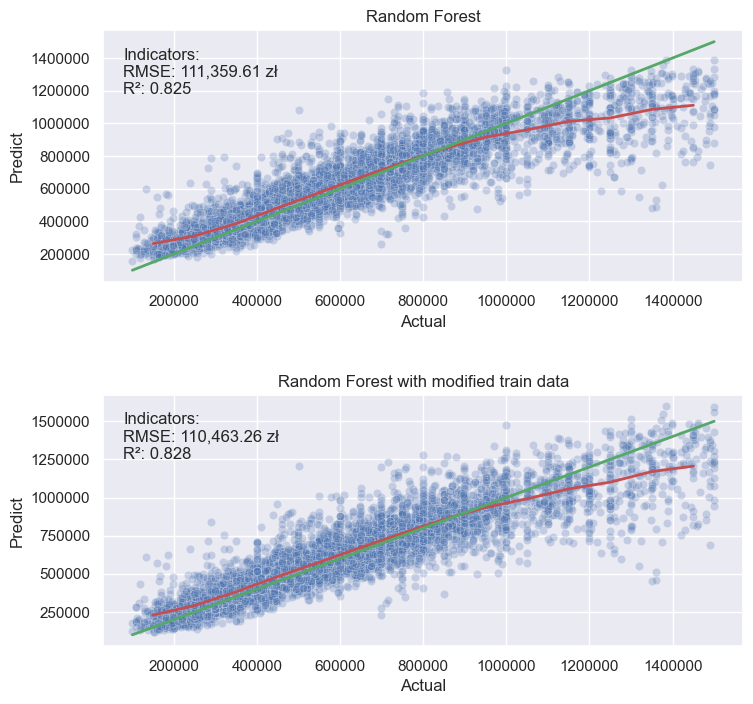

,price_bin,count,rmse_pred,rmse_pred_mod,is_modiefied_better,rmse_diff,rmse_diff_per
0,200000,191.00,121238.07,108739.32,True,12498.75,0.10
1,300000,702.00,79543.69,78358.96,True,1184.72,0.01
2,400000,1257.00,69072.23,70129.35,False,-1057.12,-0.02
3,500000,1433.00,78300.37,80252.58,False,-1952.21,-0.02
4,600000,1363.00,82065.73,84148.58,False,-2082.85,-0.03
5,700000,1151.00,83417.43,89372.78,False,-5955.35,-0.07
6,800000,747.00,107956.24,118507.09,False,-10550.85,-0.10
7,900000,506.00,106855.28,119192.70,False,-12337.42,-0.12
8,1000000,357.00,132054.23,144344.06,False,-12289.83,-0.09
9,1100000,156.00,167905.18,165438.24,True,2466.94,0.01


In [88]:
# Show prediction plots and metrics for both models
model_summary([best_rf_model, best_rf_model_modified], ["Random Forest", "Random Forest with modified train data"])

# Compare RMSE per price bin for both models
compare_unbalanced_balanced_pred(best_rf_model, best_rf_model_modified)

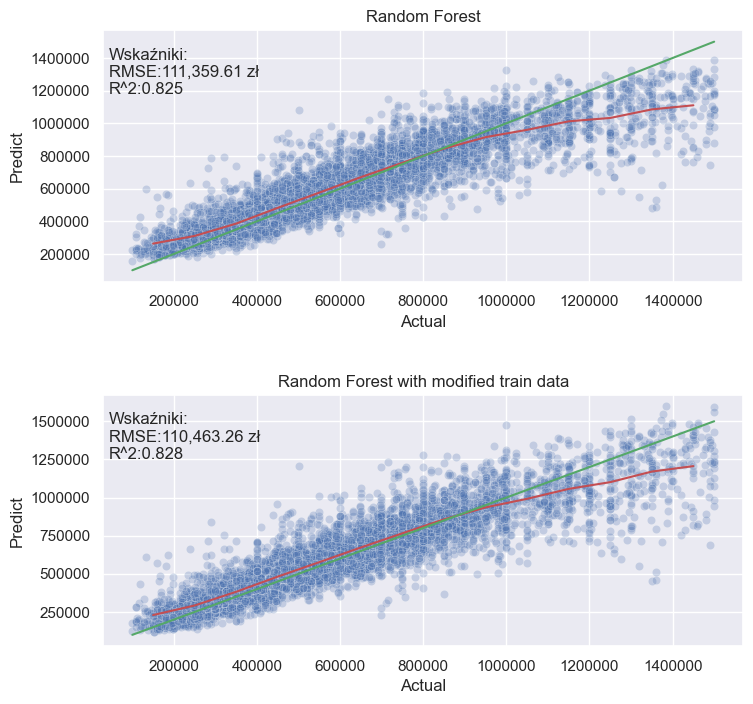

,price_bin,count,rmse_pred,rmse_pred_mod,is_modiefied_better,rmse_diff,rmse_diff_per
0,200000,191.00,121238.07,108739.32,True,12498.75,0.10
1,300000,702.00,79543.69,78358.96,True,1184.72,0.01
2,400000,1257.00,69072.23,70129.35,False,-1057.12,-0.02
3,500000,1433.00,78300.37,80252.58,False,-1952.21,-0.02
4,600000,1363.00,82065.73,84148.58,False,-2082.85,-0.03
5,700000,1151.00,83417.43,89372.78,False,-5955.35,-0.07
6,800000,747.00,107956.24,118507.09,False,-10550.85,-0.10
7,900000,506.00,106855.28,119192.70,False,-12337.42,-0.12
8,1000000,357.00,132054.23,144344.06,False,-12289.83,-0.09
9,1100000,156.00,167905.18,165438.24,True,2466.94,0.01


In [ ]:
# Reweight y_train: decrease low prices, increase high prices
(X_train_modified,
 y_train_modified) = modify_train_data(X_train, y_train,
                                       [250_000], [0.7],
                                       [1_200_000, 1_400_000], [1.1, 1.05])

# Train model on original data
best_rf_model = RandomForestRegressor(random_state = 42, n_estimators = 100,
                                      max_depth = 30, max_features = 32,
                                      min_samples_leaf = 1, min_samples_split = 2)
best_rf_model.fit(X_train, y_train)

# Train model on modified data
best_rf_model_modified = RandomForestRegressor(random_state = 42, n_estimators = 100,
                                               max_depth = 30, max_features = 32,
                                               min_samples_leaf = 1, min_samples_split = 2)
best_rf_model_modified.fit(X_train_modified, y_train_modified)

# Show prediction plots and metrics for both models
model_summary([best_rf_model, best_rf_model_modified], ["Random Forest", "Random Forest with modified train data"])

# Compare RMSE per price bin for both models
compare_unbalanced_balanced_pred(best_rf_model, best_rf_model_modified)

In [ ]:
# Define price-based reweighting settings
rf_modification_settings = {'lower_thresholds': [250_000],
                            'lower_wages': [0.7],
                            'upper_thresholds': [1_200_000, 1_400_000],
                            'upper_wages': [1.1, 1.05]}

# Save modification settings to file for future use
rf_filename = f'2. Model Building/train_data_modification/rf_modification_settings'
joblib.dump(rf_modification_settings, rf_filename)

['2. Model Building/train_data_modification/rf_modification_settings']

In [ ]:
# Save trained model to file for future use
rf_filename = f'2. Model Building/trained_models/rf_modified_model'
joblib.dump(best_rf_model_modified, rf_filename)

['2. Model Building/trained_models/rf_modified']

## XGBoost

In [ ]:
# Reweight y_train: decrease low prices, increase high prices
(X_train_modified,
 y_train_modified) = modify_train_data(X_train, y_train,
                                       [250_000], [0.7],
                                       [1_300_000], [1.1])

In [ ]:
# Initialize base XGBoost regressor
xgboost_regressor = GradientBoostingRegressor(random_state=42, n_estimators=100)

# Define hyperparameter grid for tuning
param_grid_xgboost = {
    'learning_rate': [0.01, 0.05, 0.1, 1],
    'subsample': [0.33, 0.5],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'max_features': [32, 48, 64],
    'max_depth': [30, 40, 50, 60]
}

# Perform grid search on original training data
best_xgboost_model = model_selection(xgboost_regressor, param_grid_xgboost, X_train, y_train)

# Perform grid search on modified training data
best_xgboost_model_modified = model_selection(xgboost_regressor, param_grid_xgboost, X_train_modified, y_train_modified)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Train Score: 0.9984917958204393
Test Score: 0.8346615021340024
Najlepsze parametry: {'learning_rate': 0.05, 'max_depth': 40, 'max_features': 32, 'min_samples_leaf': 1, 'min_samples_split': 2, 'subsample': 0.5}
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Train Score: 0.9983941927452422
Test Score: 0.8367184943399432
Najlepsze parametry: {'learning_rate': 0.05, 'max_depth': 50, 'max_features': 32, 'min_samples_leaf': 1, 'min_samples_split': 2, 'subsample': 0.5}


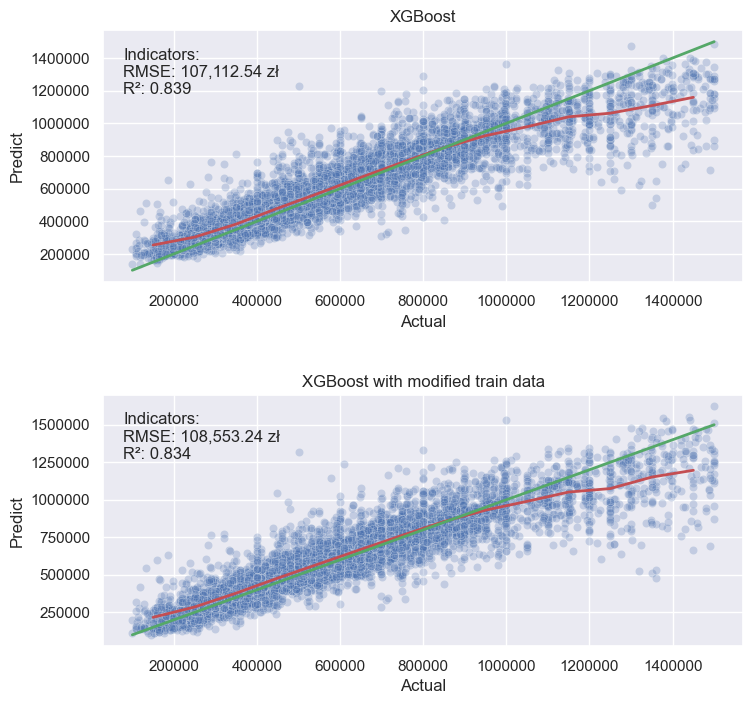

,price_bin,count,rmse_pred,rmse_pred_mod,is_modiefied_better,rmse_diff,rmse_diff_per
0,200000,191.00,115464.52,100632.51,True,14832.01,0.13
1,300000,702.00,74354.57,76201.67,False,-1847.10,-0.02
2,400000,1257.00,67518.73,69176.46,False,-1657.73,-0.02
3,500000,1433.00,77583.90,78811.41,False,-1227.50,-0.02
4,600000,1363.00,80667.09,84196.45,False,-3529.36,-0.04
5,700000,1151.00,83458.17,86336.50,False,-2878.33,-0.03
6,800000,747.00,111593.73,115864.60,False,-4270.87,-0.04
7,900000,506.00,107863.47,115590.45,False,-7726.99,-0.07
8,1000000,357.00,130228.33,136277.80,False,-6049.47,-0.05
9,1100000,156.00,151193.02,153674.18,False,-2481.16,-0.02


In [89]:
# Show prediction plots and metrics for both models
model_summary([best_xgboost_model, best_xgboost_model_modified], ["XGBoost", "XGBoost with modified train data"])

# Compare RMSE per price bin for both models
compare_unbalanced_balanced_pred(best_xgboost_model, best_xgboost_model_modified)

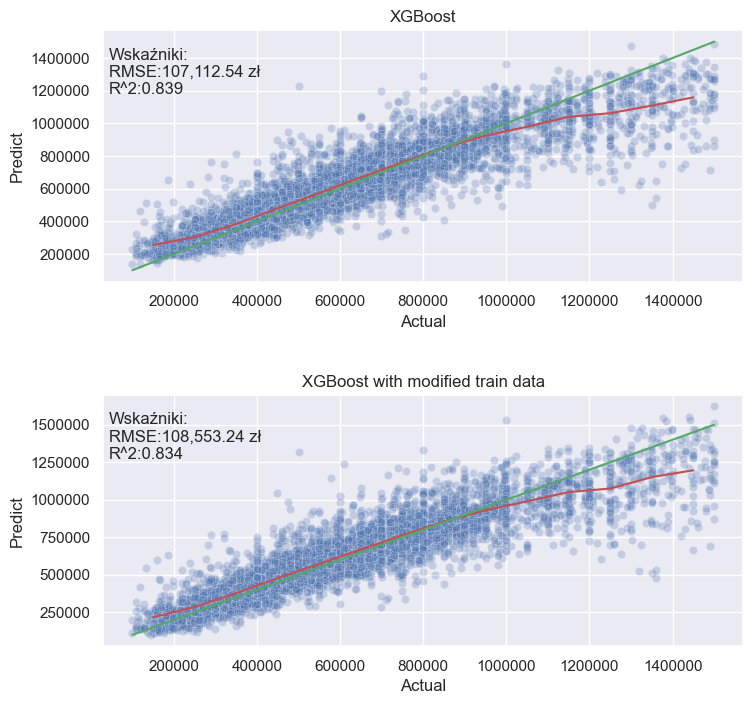

,price_bin,count,rmse_pred,rmse_pred_mod,is_modiefied_better,rmse_diff,rmse_diff_per
0,200000,191.00,115464.52,100632.51,True,14832.01,0.13
1,300000,702.00,74354.57,76201.67,False,-1847.10,-0.02
2,400000,1257.00,67518.73,69176.46,False,-1657.73,-0.02
3,500000,1433.00,77583.90,78811.41,False,-1227.50,-0.02
4,600000,1363.00,80667.09,84196.45,False,-3529.36,-0.04
5,700000,1151.00,83458.17,86336.50,False,-2878.33,-0.03
6,800000,747.00,111593.73,115864.60,False,-4270.87,-0.04
7,900000,506.00,107863.47,115590.45,False,-7726.99,-0.07
8,1000000,357.00,130228.33,136277.80,False,-6049.47,-0.05
9,1100000,156.00,151193.02,153674.18,False,-2481.16,-0.02


In [ ]:
# Reweight y_train: decrease low prices, increase high prices
(X_train_modified,
 y_train_modified) = modify_train_data(X_train, y_train,
                                       [250_000], [0.7],
                                       [1_300_000], [1.1])

# Train model on original data
best_xgboost_model = GradientBoostingRegressor(random_state = 42, n_estimators = 100,
                                               learning_rate = 0.05,
                                               max_depth = 40, max_features = 32,
                                               min_samples_leaf = 1, min_samples_split = 2,
                                               subsample = 0.5)
best_xgboost_model.fit(X_train, y_train)

# Train model on modified data
best_xgboost_model_modified = GradientBoostingRegressor(random_state = 42, n_estimators = 100,
                                                        learning_rate = 0.05,
                                                        max_depth = 50, max_features = 32,
                                                        min_samples_leaf = 1, min_samples_split = 2,
                                                        subsample = 0.5)
best_xgboost_model_modified.fit(X_train_modified, y_train_modified)

# Show prediction plots and metrics for both models
model_summary([best_xgboost_model, best_xgboost_model_modified], ["XGBoost", "XGBoost with modified train data"])

# Compare RMSE per price bin for both models
compare_unbalanced_balanced_pred(best_xgboost_model, best_xgboost_model_modified)

In [ ]:
# Define price-based reweighting settings
xgboost_modification_settings = {'lower_thresholds': [250_000],
                                 'lower_wages': [0.7],
                                 'upper_thresholds': [1_300_000],
                                 'upper_wages': [1.1]}

# Save modification settings to file for future use
xgboost_filename = f'2. Model Building/train_data_modification/xgboost_modification_settings'
joblib.dump(xgboost_modification_settings, xgboost_filename)

['2. Model Building/train_data_modification/xgboost_modification_settings']

In [ ]:
# Save trained model to file for future use
xgboost_filename = f'2. Model Building/trained_models/xgboost_modified'
joblib.dump(best_xgboost_model_modified, xgboost_filename)

['2. Model Building/trained_models/xgboost_modified']

## KNNRegressor

In [ ]:
# Reweight y_train: decrease low prices, increase high prices
(X_train_modified,
 y_train_modified) = modify_train_data(X_train, y_train,
                                       [250_000], [0.7],
                                       [1_200_000, 1_400_000], [1.15, 1.1])

In [ ]:
# Initialize base KNN regressor
knn_regressor = KNeighborsRegressor()

# Define hyperparameter grid for tuning
param_grid_knn = {
    'n_neighbors': [5, 10, 20, 30],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree'],
    'leaf_size': [50, 100, 200],
    'p': [1, 2]
}

# Perform grid search on original training data
best_knn_model = model_selection(knn_regressor, param_grid_knn, X_train, y_train)

# Perform grid search on modified training data
best_knn_model_modified = model_selection(knn_regressor, param_grid_knn, X_train_modified, y_train_modified)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Train Score: 0.9999038611308105
Test Score: 0.6856477763192192
Najlepsze parametry: {'algorithm': 'ball_tree', 'leaf_size': 50, 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Train Score: 0.9999123957777714
Test Score: 0.6803532289669463
Najlepsze parametry: {'algorithm': 'ball_tree', 'leaf_size': 50, 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}


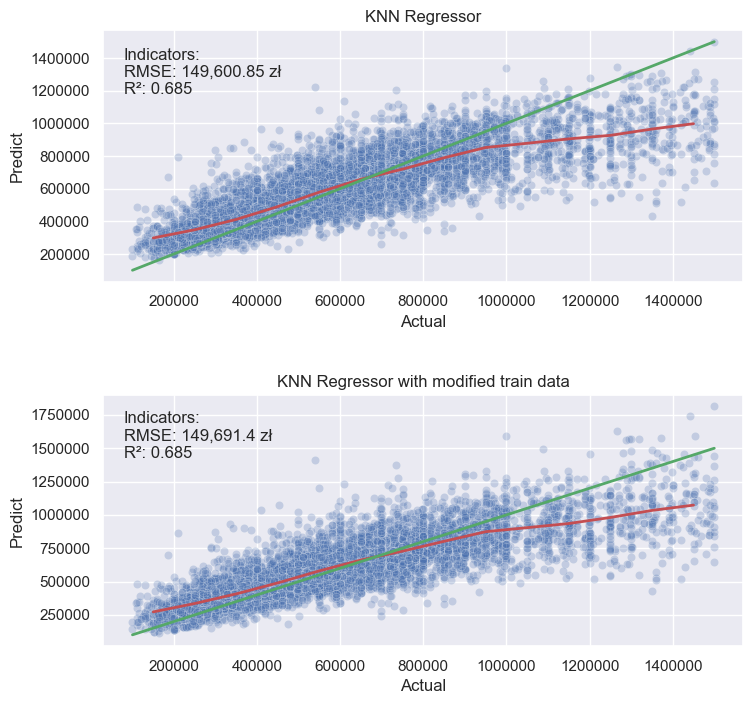

,price_bin,count,rmse_pred,rmse_pred_mod,is_modiefied_better,rmse_diff,rmse_diff_per
0,200000,191.00,150845.87,137585.72,True,13260.15,0.09
1,300000,702.00,120459.82,117978.53,True,2481.29,0.02
2,400000,1257.00,103216.49,105461.64,False,-2245.15,-0.02
3,500000,1433.00,95913.68,100244.16,False,-4330.48,-0.05
4,600000,1363.00,107310.99,113907.03,False,-6596.05,-0.06
5,700000,1151.00,106920.46,115120.15,False,-8199.69,-0.08
6,800000,747.00,132280.79,143150.53,False,-10869.74,-0.08
7,900000,506.00,146032.14,154935.25,False,-8903.11,-0.06
8,1000000,357.00,175755.93,183231.81,False,-7475.89,-0.04
9,1100000,156.00,243940.90,242738.22,True,1202.69,0.00


In [90]:
# Show prediction plots and metrics for both models
model_summary([best_knn_model, best_knn_model_modified], ["KNN Regressor", "KNN Regressor with modified train data"])

# Compare RMSE per price bin for both models
compare_unbalanced_balanced_pred(best_knn_model, best_knn_model_modified)

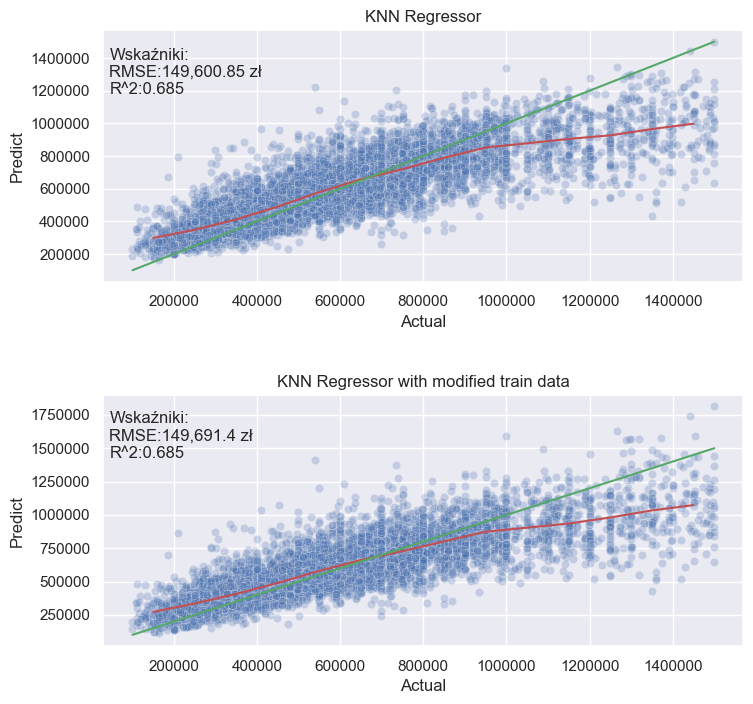

,price_bin,count,rmse_pred,rmse_pred_mod,is_modiefied_better,rmse_diff,rmse_diff_per
0,200000,191.00,150845.87,137585.72,True,13260.15,0.09
1,300000,702.00,120459.82,117978.53,True,2481.29,0.02
2,400000,1257.00,103216.49,105461.64,False,-2245.15,-0.02
3,500000,1433.00,95913.68,100244.16,False,-4330.48,-0.05
4,600000,1363.00,107310.99,113907.03,False,-6596.05,-0.06
5,700000,1151.00,106920.46,115120.15,False,-8199.69,-0.08
6,800000,747.00,132280.79,143150.53,False,-10869.74,-0.08
7,900000,506.00,146032.14,154935.25,False,-8903.11,-0.06
8,1000000,357.00,175755.93,183231.81,False,-7475.89,-0.04
9,1100000,156.00,243940.90,242738.22,True,1202.69,0.00


In [ ]:
# Reweight y_train: decrease low prices, increase high prices
(X_train_modified,
 y_train_modified) = modify_train_data(X_train, y_train,
                                       [250_000], [0.7],
                                       [1_200_000, 1_400_000], [1.1, 1.1])

# Train model on original data
best_knn_model = KNeighborsRegressor(n_neighbors = 10,
                                     weights = "distance",
                                     algorithm = "ball_tree",
                                     leaf_size = 100,
                                     p = 1)
best_knn_model.fit(X_train, y_train)

# Train model on modified data
best_knn_model_modified = KNeighborsRegressor(n_neighbors = 10,
                                              weights = "distance",
                                              algorithm = "ball_tree",
                                              leaf_size = 100,
                                              p = 1)
best_knn_model_modified.fit(X_train_modified, y_train_modified)

# Show prediction plots and metrics for both models
model_summary([best_knn_model, best_knn_model_modified], ["KNN Regressor", "KNN Regressor with modified train data"])

# Compare RMSE per price bin for both models
compare_unbalanced_balanced_pred(best_knn_model, best_knn_model_modified)

In [ ]:
# Define price-based reweighting settings
knn_modification_settings = {'lower_thresholds': [250_000],
                             'lower_wages': [0.7],
                             'upper_thresholds': [1_200_000, 1_400_000],
                             'upper_wages': [1.1, 1.1]}

# Save modification settings to file for future use
knn_filename = f'2. Model Building/train_data_modification/knn_modification_settings'
joblib.dump(knn_modification_settings, knn_filename)

['2. Model Building/train_data_modification/knn_modification_settings']

In [ ]:
# Save trained model to file for future use
knn_filename = f'2. Model Building/trained_models/knn_modified'
joblib.dump(best_knn_model_modified, knn_filename)

['2. Model Building/trained_models/knn_modified']

## MLPRegressor

In [ ]:
# Reweight y_train: decrease low prices, increase high prices
(X_train_modified,
 y_train_modified) = modify_train_data(X_train, y_train,
                                       [250_000], [0.7],
                                       [1_200_000], [1.1])

In [ ]:
# Initialize base MLP regressor
mlp_regressor = MLPRegressor(max_iter = 100, learning_rate = 'constant',
                             early_stopping = True, random_state = 99)

# Define hyperparameter grid for tuning
param_grid_mlp = {
    'hidden_layer_sizes': [(200,2), (150,2), (150,1), (100,2), (25,2)],
    'learning_rate_init': [0.05, 0.1, 0.15],
    'n_iter_no_change': [2, 5]
}

# Perform grid search on original training data
best_mlp_model = model_selection(mlp_regressor, param_grid_mlp, X_train, y_train)

# Perform grid search on modified training data
best_mlp_model_modified = model_selection(mlp_regressor, param_grid_mlp, X_train_modified, y_train_modified)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Train Score: 0.8238149602637574
Test Score: 0.7806431273043083
Najlepsze parametry: {'hidden_layer_sizes': (150, 2), 'learning_rate_init': 0.1, 'n_iter_no_change': 5}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Train Score: 0.8109303040385684
Test Score: 0.7810829251099596
Najlepsze parametry: {'hidden_layer_sizes': (150, 1), 'learning_rate_init': 0.1, 'n_iter_no_change': 5}


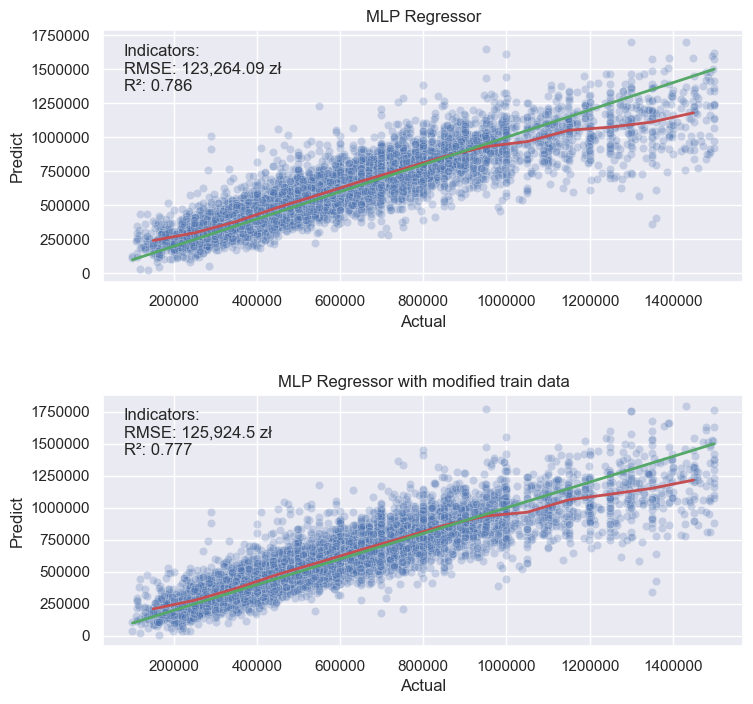

,price_bin,count,rmse_pred,rmse_pred_mod,is_modiefied_better,rmse_diff,rmse_diff_per
0,200000,191.00,108203.87,106372.36,True,1831.50,0.02
1,300000,702.00,92112.00,92299.74,False,-187.75,-0.00
2,400000,1257.00,81246.78,85753.72,False,-4506.94,-0.06
3,500000,1433.00,93788.13,96297.72,False,-2509.58,-0.03
4,600000,1363.00,98305.72,100520.19,False,-2214.48,-0.02
5,700000,1151.00,102349.70,105957.91,False,-3608.20,-0.04
6,800000,747.00,127611.47,134147.85,False,-6536.38,-0.05
7,900000,506.00,130529.72,143614.72,False,-13085.01,-0.10
8,1000000,357.00,162895.27,172343.01,False,-9447.74,-0.06
9,1100000,156.00,181947.49,189338.37,False,-7390.88,-0.04


In [91]:
# Show prediction plots and metrics for both models
model_summary([best_mlp_model, best_mlp_model_modified], ["MLP Regressor", "MLP Regressor with modified train data"])

# Compare RMSE per price bin for both models
compare_unbalanced_balanced_pred(best_mlp_model, best_mlp_model_modified)

c:\Users\krasavica\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\krasavica\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


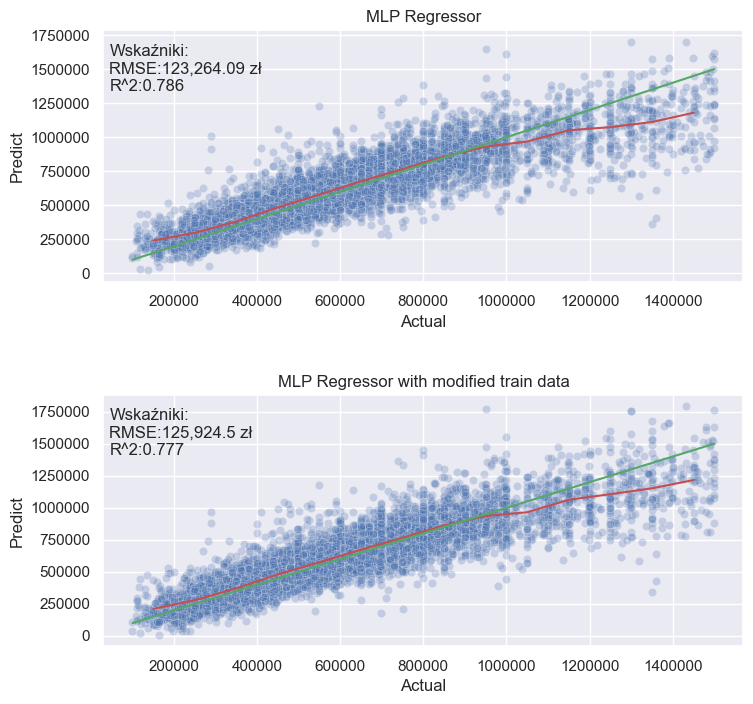

,price_bin,count,rmse_pred,rmse_pred_mod,is_modiefied_better,rmse_diff,rmse_diff_per
0,200000,191.00,108203.87,106372.36,True,1831.50,0.02
1,300000,702.00,92112.00,92299.74,False,-187.75,-0.00
2,400000,1257.00,81246.78,85753.72,False,-4506.94,-0.06
3,500000,1433.00,93788.13,96297.72,False,-2509.58,-0.03
4,600000,1363.00,98305.72,100520.19,False,-2214.48,-0.02
5,700000,1151.00,102349.70,105957.91,False,-3608.20,-0.04
6,800000,747.00,127611.47,134147.85,False,-6536.38,-0.05
7,900000,506.00,130529.72,143614.72,False,-13085.01,-0.10
8,1000000,357.00,162895.27,172343.01,False,-9447.74,-0.06
9,1100000,156.00,181947.49,189338.37,False,-7390.88,-0.04


In [ ]:
# Reweight y_train: decrease low prices, increase high prices
(X_train_modified,
 y_train_modified) = modify_train_data(X_train, y_train,
                                       [250_000], [0.7],
                                       [1_200_000], [1.1])

# Train model on original data
best_mlp_model = MLPRegressor(max_iter = 100,
                              learning_rate = 'constant',
                              hidden_layer_sizes = (150,2),
                              learning_rate_init = 0.1,
                              n_iter_no_change = 5)
best_mlp_model.fit(X_train, y_train)

# Train model on modified data
best_mlp_model_modified = MLPRegressor(max_iter = 100,
                                       learning_rate = 'constant',
                                       hidden_layer_sizes = (150,1),
                                       learning_rate_init = 0.1,
                                       n_iter_no_change = 5)
best_mlp_model_modified.fit(X_train_modified, y_train_modified)

# Show prediction plots and metrics for both models
model_summary([best_mlp_model, best_mlp_model_modified], ["MLP Regressor", "MLP Regressor with modified train data"])

# Compare RMSE per price bin for both models
compare_unbalanced_balanced_pred(best_mlp_model, best_mlp_model_modified)

In [ ]:
# Define price-based reweighting settings
mlp_modification_settings = {'lower_thresholds': [250_000],
                             'lower_wages': [0.7],
                             'upper_thresholds': [1_200_000],
                             'upper_wages': [1.1]}

# Save modification settings to file for future use
mlp_filename = f'2. Model Building/train_data_modification/mlp_modification_settings'
joblib.dump(mlp_modification_settings, mlp_filename)

['2. Model Building/train_data_modification/mlp_modification_settings']

In [ ]:
# Save trained model to file for future use
mlp_filename = f'2. Model Building/trained_models/mlp_modified'
joblib.dump(best_mlp_model_modified, mlp_filename)

['2. Model Building/trained_models/mlp_modified']

# Compearing models
A comparison of the RMSE coefficient for the best models from each method is made below. <br><br>
<b>Conclusions:</b><br>
The XGBoost model had the smallest RMSE. Random Forest had a smaller error for some ranges, meanwhile it was decided that only XGBoost would be taken as the final model.


In [ ]:
# Calculating predictions for selected models
pred_rf = best_rf_model_modified.predict(X_test)
pred_rf_df = pd.DataFrame(pred_rf, index=y_test.index, columns=["pred_rf"])

pred_xgboost = best_xgboost_model_modified.predict(X_test)
pred_xgboost_df = pd.DataFrame(pred_xgboost, index=y_test.index, columns=["pred_xgboost"])

pred_knn = best_knn_model_modified.predict(X_test)
pred_knn_df = pd.DataFrame(pred_knn, index=y_test.index, columns=["pred_knn"])

pred_mlp = best_mlp_model_modified.predict(X_test)
pred_mlp_df = pd.DataFrame(pred_mlp, index=y_test.index, columns=["pred_mlp"])

In [77]:
# Create price bins for test target values
x_bins = pd.DataFrame(pd.cut(
    y_test,
    bins=range(100_000, 1_500_001, 100_000),
    labels=np.arange(200_000, 1_500_001, 100_000)
))

# Combine actual and predicted values from all models
df = pd.concat([x_bins, y_test, pred_rf_df, pred_xgboost_df, pred_knn_df, pred_mlp_df], axis=1)
df.columns = ["price_bin", "actual", "pred_rf", "pred_xgboost", "pred_knn", "pred_mlp"]

# Calculate RMSE for each model within each price bin
rmse_df = df.groupby("price_bin", observed=False).apply(
    lambda g: pd.Series({
        "count": len(g['actual']),
        "rmse_pred_rf": metrics.root_mean_squared_error(g['actual'], g['pred_rf']),
        "rmse_pred_xgboost": metrics.root_mean_squared_error(g['actual'], g['pred_xgboost']),
        "rmse_pred_knn": metrics.root_mean_squared_error(g['actual'], g['pred_knn']),
        "rmse_pred_mlp": metrics.root_mean_squared_error(g['actual'], g['pred_mlp'])
    }),
    include_groups=False
).reset_index()

# Add overall RMSE values across all data (not grouped by bin)
rmse_df.loc[len(rmse_df)] = {
    "price_bin": "All",
    "count": len(df['actual']),
    "rmse_pred_rf": metrics.root_mean_squared_error(df['actual'], df['pred_rf']),
    "rmse_pred_xgboost": metrics.root_mean_squared_error(df['actual'], df['pred_xgboost']),
    "rmse_pred_knn": metrics.root_mean_squared_error(df['actual'], df['pred_knn']),
    "rmse_pred_mlp": metrics.root_mean_squared_error(df['actual'], df['pred_mlp'])
}

# Select RMSE columns to compare models
rmse_cols = ["rmse_pred_rf", "rmse_pred_xgboost", "rmse_pred_knn", "rmse_pred_mlp"]

# Determine best model (lowest RMSE) per price bin
rmse_df["best_model"] = rmse_df[rmse_cols].idxmin(axis=1)

# Remove prefix from model names for cleaner output
rmse_df["best_model"] = rmse_df["best_model"].str.replace("rmse_pred_", "", regex=False)

# Display RMSE summary table
rmse_df


,price_bin,count,rmse_pred_rf,rmse_pred_xgboost,rmse_pred_knn,rmse_pred_mlp,best_model
0,200000,191.00,108739.32,100632.51,137585.72,106372.36,xgboost
1,300000,702.00,78358.96,76201.67,117978.53,92299.74,xgboost
2,400000,1257.00,70129.35,69176.46,105461.64,85753.72,xgboost
3,500000,1433.00,80252.58,78811.41,100244.16,96297.72,xgboost
4,600000,1363.00,84148.58,84196.45,113907.03,100520.19,rf
5,700000,1151.00,89372.78,86336.50,115120.15,105957.91,xgboost
6,800000,747.00,118507.09,115864.60,143150.53,134147.85,xgboost
7,900000,506.00,119192.70,115590.45,154935.25,143614.72,xgboost
8,1000000,357.00,144344.06,136277.80,183231.81,172343.01,xgboost
9,1100000,156.00,165438.24,153674.18,242738.22,189338.37,xgboost


# Final model settings

In [ ]:
# Show selected model and model parameters
print(best_xgboost_model_modified.get_params)

# Show modification settings for train data
print(xgboost_modification_settings)

<bound method BaseEstimator.get_params of GradientBoostingRegressor(learning_rate=0.05, max_depth=50, max_features=32,
                          random_state=42, subsample=0.5)>
{'lower_thresholds': [250000], 'lower_wages': [0.7], 'upper_thresholds': [1300000], 'upper_wages': [1.1]}


In [ ]:
# Define final model and model parameters
final_model_params = GradientBoostingRegressor(learning_rate = 0.05,
                                               max_depth = 50,
                                               max_features = 32,
                                               random_state = 42,
                                               subsample = 0.5)

# Define final modification settings for train data
final_modification_settings = {'lower_thresholds': [250_000],
                               'lower_wages': [0.7],
                               'upper_thresholds': [1_300_000],
                               'upper_wages': [1.1]}

In [ ]:
# Save final model and model parameters
final_model_params_filename = f'2. Model Building/final_model_params'
joblib.dump(final_model_params, final_model_params_filename)

# Save final modification settings for train data
final_modification_settings_filename = f'2. Model Building/final_modification_settings'
joblib.dump(final_modification_settings, final_modification_settings_filename)

['2. Model Building/final_modification_settings']